In [424]:
import numpy as np
import os
import os.path as op
import array
import matplotlib.pyplot as plt
import seaborn as sns

In [584]:
data_dir = "/mnt/home/tyerxa/ceph/datasets/datasets/vanhateren_imc"
files = sorted(os.listdir(data_dir))
n_images = 10
rand_idx = np.random.choice(range(len(files)), n_images, replace=False)

filename = files[0]
with open(op.join(data_dir, filename), 'rb') as handle:
    s = handle.read()
    arr = array.array('H', s)
    arr.byteswap()
img = np.array(arr, dtype='uint16').reshape(1024, 1536)
H, W = img.shape
# img = img[:, :1024] # taking this to make images square
# random 256 x 256 crop
crop_size = 256
VMIN, VMAX = 0, 2**16
# rand_h, rand_w = np.random.randint(0, 1024 - 256, 2)
rand_h = np.random.randint(0, H-crop_size, 1)[0]
rand_w = np.random.randint(0, W-crop_size, 1)[0]
print(rand_h, rand_w)
img = img[rand_h:rand_h + crop_size, rand_w:rand_w + crop_size]
img = img / np.max(img)

239 613


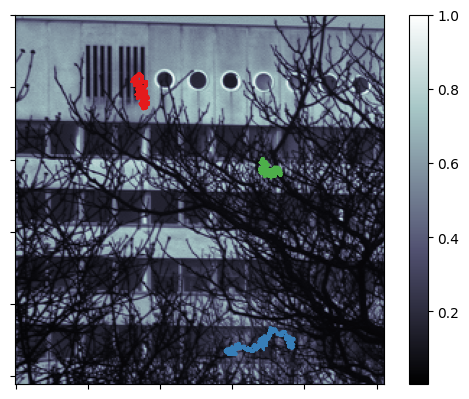

In [699]:
def random_walk(n_steps, sigma=1.0):
    # 2d gaussian random walk
    x = np.random.normal(0, sigma, n_steps)
    y = np.random.normal(0, sigma, n_steps)
    return np.cumsum(x).astype(int), np.cumsum(y).astype(int)

def get_patches(img, walk_h, walk_w):
    all_images = []
    for di, dj in zip(walk_h, walk_w):
        all_images.append(img[di:di+h, dj:dj+w])
    return all_images

def get_contexts(img, h, w, n_contexts, sigma, n_steps, pad_factor=1):
    pad_h, pad_w = pad_factor * h, pad_factor * w

    all_contexts = []
    walk_coords = []

    for _ in range(n_contexts):
        i, j = np.random.randint(pad_h, img_h-pad_w), np.random.randint(pad_h, img_w-pad_w)
        walk_h, walk_w = random_walk(n_steps, sigma)
        walk_h = np.clip(walk_h+i, 0+h, img_h-h)
        walk_w = np.clip(walk_w+j, 0+w, img_w-w)
        all_contexts.append(get_patches(img, walk_h, walk_w))
        walk_coords.append(np.stack([walk_h, walk_w], axis=1))

    return np.array(all_contexts), walk_coords


h, w = 20, 20
img_h, img_w = img.shape

sigma = .1
n_steps = 20_000

fig, ax = plt.subplots(1, 1)
im = ax.imshow(img, cmap="bone")
plt.colorbar(im)
ax.set(xticklabels=[], yticklabels=[])

n_contexts = 3
cols = sns.color_palette("Set1", n_contexts)

all_contexts, walk_coords = get_contexts(img, h, w, n_contexts, sigma, n_steps, pad_factor=1)
for idx, walk_hw in enumerate(walk_coords):
    walk_h, walk_w = walk_hw[:, 0], walk_hw[:, 1]
    ax.plot(walk_h, walk_w, color=cols[idx])

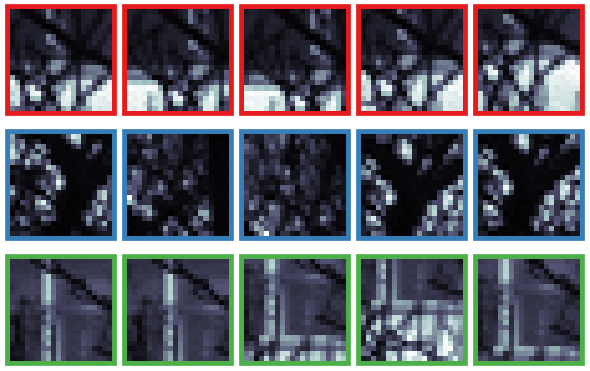

In [701]:
# sample 5 images without replacement from all_images and plot
def add_subplot_border(ax, width=1, color=None ):
    """from https://stackoverflow.com/questions/45441909/how-to-add-a-fixed-width-border-to-subplot"""

    fig = ax.get_figure()

    # Convert bottom-left and top-right to display coordinates
    x0, y0 = ax.transAxes.transform((0, 0))
    x1, y1 = ax.transAxes.transform((1, 1))

    # Convert back to Axes coordinates
    x0, y0 = ax.transAxes.inverted().transform((x0, y0))
    x1, y1 = ax.transAxes.inverted().transform((x1, y1))

    rect = plt.Rectangle(
        (x0, y0), x1-x0, y1-y0,
        color=color,
        transform=ax.transAxes,
        zorder=-1,
        lw=2*width+1,
        fill=None,
    )
    fig.patches.append(rect)

def plot_context_samples(all_contexts, n_samples):
    n_contexts = all_contexts.shape[0]
    sampled_idx = np.random.choice(n_steps, n_samples, replace=False)
    fig, ax = plt.subplots(n_contexts, 5, figsize=(6, 4))
    for ctx in range(n_contexts):
        VMIN, VMAX = np.min(all_contexts[ctx]), np.max(all_contexts[ctx])
        for i in range(5):
            ax[ctx, i].imshow(all_contexts[ctx][sampled_idx[i]], cmap="bone", vmin=VMIN, vmax=VMAX)
            add_subplot_border(ax[ctx, i], width=3, color=cols[ctx])
            ax[ctx, i].axis("off")

    fig.tight_layout()

plot_context_samples(all_contexts, 5)

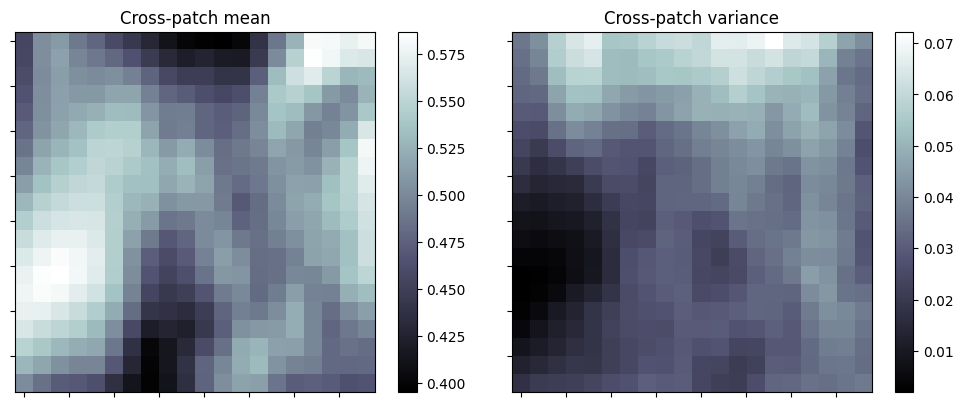

In [683]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex="all", sharey="all")

ctx = 1
I = all_contexts[ctx]
im = ax[0].imshow(np.mean(I, 0), cmap="bone")
cbar = plt.colorbar(im)
ax[0].set(title="Cross-patch mean")

im = ax[1].imshow(np.var(I, 0), cmap="bone")
ax[1].set(title="Cross-patch variance", xticklabels=[], yticklabels=[])
cbar = plt.colorbar(im)
fig.tight_layout()